In [ ]:
!pip -q install langchain-core langchain-community langgraph langchain-openai duckduckgo-search

## LangGraph ReAct Function Calling Pattern

- Search

- Math

---



react_prompt = """O Assistente é um grande modelo de linguagem treinado pela Microsoft.

O Assistente foi projetado para ser capaz de ajudar em uma ampla gama de tarefas, desde responder perguntas simples até fornecer explicações detalhadas e discussões sobre uma ampla variedade de tópicos. Como um modelo de linguagem, o Assistente é capaz de gerar texto semelhante ao humano com base na entrada que recebe, permitindo que ele se envolva em conversas que soam naturais e forneça respostas que sejam coerentes e relevantes para o tópico em questão.

O Assistente está constantemente aprendendo e melhorando, e suas capacidades estão em constante evolução. Ele é capaz de processar e entender grandes quantidades de texto e pode usar esse conhecimento para fornecer respostas precisas e informativas a uma ampla gama de perguntas. Além disso, o Assistente é capaz de gerar seu próprio texto com base na entrada que recebe, permitindo que ele participe de discussões e forneça explicações e descrições sobre uma ampla variedade de tópicos.

No geral, o Assistente é uma ferramenta poderosa que pode ajudar em uma ampla gama de tarefas e fornecer insights e informações valiosas sobre uma ampla gama de tópicos. Seja você precisando de ajuda com uma pergunta específica ou apenas querendo ter uma conversa sobre um determinado tópico, o Assistente está aqui para ajudar.

FERRAMENTAS:
------

O Assistente tem acesso às seguintes ferramentas:

pesquisa_wikipedia - busca na base de dados da Wikipedia pela resposta\n
pesquisa_web - busca na web pela resposta\n
calculadora - calcula a resposta para a pergunta\n
api_clima - obtém a previsão do tempo para a localização\n

Para usar uma ferramenta, por favor, use o seguinte formato:

Pensamento: Preciso usar uma ferramenta? Sim Ação: a ação a ser tomada, deve ser uma das [pesquisa_wikipedia, pesquisa_web, calculadora, api_clima]

Entrada da Ação: a entrada para a ação Observação: o resultado da ação

Quando você tiver uma resposta a dar ao Humano, ou se não precisar usar uma ferramenta, você DEVE usar o formato:

Pensamento: Preciso usar uma ferramenta? Não Resposta Final: [sua resposta aqui]

Comece!


In [ ]:
import os
from google.colab import userdata

os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')


In [ ]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o")

### Tools

In [ ]:

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

In [ ]:
# search tools
from langchain_community.tools import DuckDuckGoSearchRun

search = DuckDuckGoSearchRun()

search.invoke("How old is Brad Pitt?")

'Brad Pitt. Photo: Amy Sussman/Getty Images. Brad Pitt is opening up about growing older. The Oscar winner, 60, and George Clooney, 63, spoke with GQ in an interview published on Tuesday, August 13 ... Brad Pitt marked his 60th birthday with a celebration at Mother Wolf in Los Angeles this week. One onlooker says the actor \'looked super happy\' at the party, and \'everyone had a smile on their faces.\' Brad Pitt is an American actor born on December 18, 1963, in Shawnee, Oklahoma. He has starred in various films, won an Academy Award, and married Angelina Jolie. Brad Pitt rang in his six-decade milestone in a big way — twice! Pitt celebrated his 60th birthday on Monday, along with friends and his girlfriend, Ines de Ramon, 33, with "low key ... Brad Pitt\'s net worth is estimated to be around $400 million. His acting career alone has contributed significantly to this, with Pitt commanding as much as $20 million per film. ... Born on December 18, 1963, Brad Pitt is 61 years old. His zo

In [ ]:
tools = [add, multiply, divide, search]

llm_with_tools = llm.bind_tools(tools)

In [ ]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with using search and performing arithmetic on a set of inputs.")



## Nodes

In [ ]:
# Node
def reasoner(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}


### Building the graph

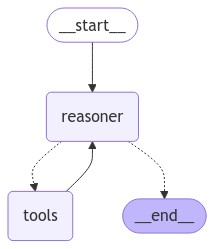

In [ ]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition # this is the checker for the if you got a tool back
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

# Graph
builder = StateGraph(MessagesState)

# Add nodes
builder.add_node("reasoner", reasoner)
builder.add_node("tools", ToolNode(tools)) # for the tools

# Add edges
builder.add_edge(START, "reasoner")
builder.add_conditional_edges(
    "reasoner",
    # If the latest message (result) from node reasoner is a tool call -> tools_condition routes to tools
    # If the latest message (result) from node reasoner is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "reasoner")
react_graph = builder.compile()

# Display the graph
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
messages = [HumanMessage(content="What is 2 times Brad Pitt's age?")]
messages = react_graph.invoke({"messages": messages})

In [ ]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What is 2 times Brad Pitt's age?
================================== Ai Message ==================================
Tool Calls:
  duckduckgo_search (call_Ll4tmu9e4PnAqAqcDx7y1byP)
 Call ID: call_Ll4tmu9e4PnAqAqcDx7y1byP
  Args:
    query: Brad Pitt age
================================= Tool Message =================================
Name: duckduckgo_search

Brad Pitt's Age & Height Pitt Is a Sagittarius Born on December 18, 1963, Brad Pitt is 61 years old. His zodiac sign is Sagittarius who are known for being adventurous, independent, and passionate—traits that have been central to Pitt's successful career. Whether he's taking ... Brad Pitt Says He Became 'More Aware of' Mortality After Turning 60. ... who is a few years older, reminisced on being Pitt's current age. "When I turned 60, my wife and I had a nice dinner. We ... Brad Pitt (born December 18, 1963, Shawnee, Oklahoma, U.S.) is an American actor kn

## More manual way and adding a custom tool

In [ ]:
!pip -q install yahoo-finance

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 3.9 MB/s eta 0:00:00


In [ ]:
import yfinance as yf

def get_stock_price(ticker: str) -> float:
    """Gets a stock price from Yahoo Finance.

    Args:
        ticker: ticker str
    """
    # """This is a tool for getting the price of a stock when passed a ticker symbol"""
    stock = yf.Ticker(ticker)
    return stock.info['previousClose']

In [ ]:
get_stock_price("AAPL")

222.5

In [ ]:
# from langchain_community.tools.yahoo_finance_news import YahooFinanceNewsTool

# y_finance = YahooFinanceNewsTool()

# y_finance.invoke("AAPL")

In [ ]:
# Node
def reasoner(state):
    query = state["query"]
    messages = state["messages"]
    # System message
    sys_msg = SystemMessage(content="You are a helpful assistant tasked with using search, the yahoo finance tool and performing arithmetic on a set of inputs.")
    message = HumanMessage(content=query)
    messages.append(message)
    result = [llm_with_tools.invoke([sys_msg] + messages)]
    return {"messages":result}


In [ ]:
tools = [add, multiply, divide, search, get_stock_price]

llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools(tools)

In [ ]:
tools[4]

<function __main__.get_stock_price(ticker: str) -> float>

In [ ]:
from typing import Annotated, TypedDict
import operator
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages


class GraphState(TypedDict):
    """State of the graph."""
    query: str
    finance: str
    final_answer: str
    # intermediate_steps: Annotated[list[tuple[AgentAction, str]], operator.add]
    messages: Annotated[list[AnyMessage], operator.add]


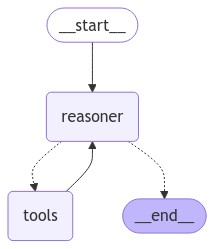

In [ ]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition # this is the checker for the
from langgraph.prebuilt import ToolNode


# Graph
workflow = StateGraph(GraphState)

# Add Nodes
workflow.add_node("reasoner", reasoner)
workflow.add_node("tools", ToolNode(tools)) # for the tools

# Add Edges
workflow.add_edge(START, "reasoner")

workflow.add_conditional_edges(
    "reasoner",
    # If the latest message (result) from node reasoner is a tool call -> tools_condition routes to tools
    # If the latest message (result) from node reasoner is a not a tool call -> tools_condition routes to END
    tools_condition,
)
workflow.add_edge("tools", "reasoner")
react_graph = workflow.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
response = react_graph.invoke({"query": "What is 2 times Brad Pitt's age?", "messages": []})

In [ ]:
response['messages'][-1].pretty_print()

================================== Ai Message ==================================

2 times Brad Pitt's age (60) is 120.


In [ ]:
response = react_graph.invoke({"query": "What is the stock price of Apple?", "messages": []})

In [ ]:
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

What is the stock price of Apple?
================================== Ai Message ==================================
Tool Calls:
  get_stock_price (call_X7Y8xbdMg2vo2bI2C6hal7Gz)
 Call ID: call_X7Y8xbdMg2vo2bI2C6hal7Gz
  Args:
    ticker: AAPL
================================= Tool Message =================================
Name: get_stock_price

222.5
================================ Human Message =================================

What is the stock price of Apple?
================================== Ai Message ==================================

The stock price of Apple (AAPL) is $222.50.


In [ ]:
response = react_graph.invoke({"query": "What is the stock price of the company that Jensen Huang is CEO of?", "messages": []})

In [ ]:
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

What is the stock price of the company that Jensen Huang is CEO of?
================================== Ai Message ==================================
Tool Calls:
  duckduckgo_search (call_Lx0D1F4vLFCKEPWAVKWn3Dbr)
 Call ID: call_Lx0D1F4vLFCKEPWAVKWn3Dbr
  Args:
    query: Jensen Huang CEO company
================================= Tool Message =================================
Name: duckduckgo_search

Jensen Huang: from Denny's dishwasher to CEO of Nvidia | 60 Minutes 13:23. Only four companies in the world are worth more than $2 trillion: Microsoft, Apple, Alphabet — parent company of Google ... Nvidia CEO Jensen Huang launched his company in a booth at Denny's with his friends. Meet his cofounder who donated shares now worth $70 billion and moved off the grid ... Jensen Huang, Chris ... Nvidia CEO Jensen Huang delivers his keynote speech ahead of Computex 2024 in Taipei on June 2, 2024. When Nvidia surpas

In [ ]:
response = react_graph.invoke({"query": "What will be the price of nvidia stock if it doubles?", "messages": []})

In [ ]:
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

What will be the price of nvidia stock if it doubles?
================================== Ai Message ==================================
Tool Calls:
  get_stock_price (call_8iPPMM261Ddgr4LdAlhQ4wW9)
 Call ID: call_8iPPMM261Ddgr4LdAlhQ4wW9
  Args:
    ticker: NVDA
================================= Tool Message =================================
Name: get_stock_price

119.1
================================ Human Message =================================

What will be the price of nvidia stock if it doubles?
================================== Ai Message ==================================
Tool Calls:
  multiply (call_uiTbfZ1pyR4TGayOPHXT1vZB)
 Call ID: call_uiTbfZ1pyR4TGayOPHXT1vZB
  Args:
    a: 11910
    b: 2
================================= Tool Message =================================
Name: multiply

23820
================================ Human Message =================================

What will be the pr

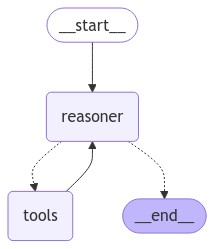

In [ ]:
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))